# Normalization

In [98]:
import matplotlib.pyplot as plt
import re
import nltk
import networkx as nx
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from scipy import spatial
import numpy as np

In [54]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.stem import PorterStemmer

f = open("dataset.txt")
original_text = f.read()
lower_text = original_text.lower()  # нижний регистр
 
no_number_text = re.sub(r'\d+','',lower_text)  # убираем числа
 
no_punc_text = re.sub(r'[^\w\s]','', no_number_text)  # убираем пунктуацию
 
no_wspace_text = no_punc_text.strip()  # убираем пробелы
 
lst_string = [no_wspace_text][0].split()  # строка в список
porter = PorterStemmer()

no_stopwords_string=""
no_stopwords_list=[]         # убираем стоп-слова
for i in lst_string:
    if not i in stop_words:
        no_stopwords_string += i+' '
        no_stopwords_list.append(porter.stem(i))
        #no_stopwords_list.append(i)
       # if len(no_stopwords_list)>4:                                  # убираем элемент, чтобы не образовывалось петель
       #     if no_stopwords_list[-1] in no_stopwords_list[-4:-1]:
       #         no_stopwords_list.pop()

            
no_stopwords_list = no_stopwords_list[:-1]   #убираем последний пробел


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Кристина\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В результате нормализации получаем список основ слов без суффиксов и окончаний, которые входят в текст. В нем отсутствуют "стоп-слова": предлоги, частицы, междометия и тд.

# Text-to-Network Conversion

In [10]:
G = nx.Graph()

In [11]:
G.add_nodes_from(no_stopwords_list)

Построим граф с весами ребер 1,2,3. Вес 3 означает, что в тексте слова стоят рядом, 2 - между словами-вершинами в тексте стоит еще слово и 1 - слова разделяют другие 2 слова.

In [12]:
for edge in range(0, len(no_stopwords_list[:-4])):
    G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+1], weight = 3)
    G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+2], weight = 2)
    G.add_edge(no_stopwords_list[edge], no_stopwords_list[edge+3], weight = 1)
G.add_edge(no_stopwords_list[-3], no_stopwords_list[-2], weight = 2)
G.add_edge(no_stopwords_list[-3], no_stopwords_list[-1], weight = 1)
G.add_edge(no_stopwords_list[-2], no_stopwords_list[-1], weight = 1)

Визуализируем граф, построеный на небольшом тексте. На графе мы видим хабы - вершины с большим количеством ребер, то есть это слова, которые встречаются в тексте не раз и связаны с большим количеством других слов. Будем считать, что такие слова самые важные и формируют основной смысл текста. Видим,что иногда образуются петли, их можно убрать на этапе нормализации текста, однако они тоже вносят вклад в вес отдельного слова, поэтому их следует оставить.

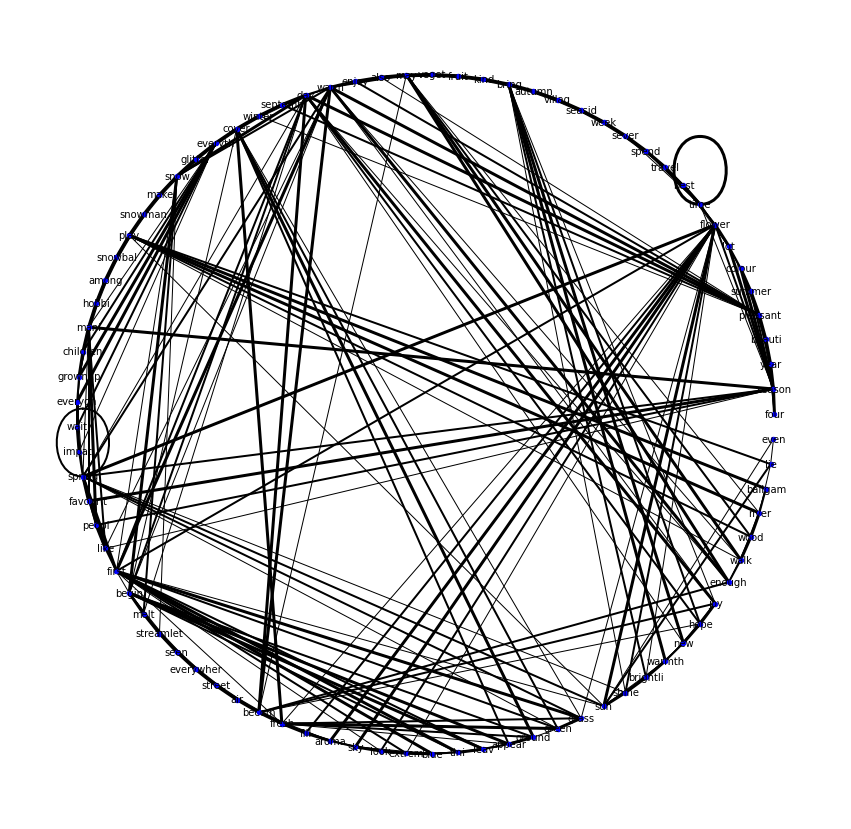

In [228]:
plt.figure(figsize=(15,15))
edges=G.edges()
weights = [G[u][v]['weight'] for u,v in edges]
pos = nx.circular_layout(G)
nodes = nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue')
edges = nx.draw_networkx_edges(G, pos, node_size=20, width=weights)
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

#nx.draw(G, pos, with_labels=False, node_size=20)
plt.xlim(-1.2, 1.2)
plt.ylim(-1.2, 1.2)
plt.axis("off")
plt.show()

# Extracting Most Influential Keywords Using Closeness, Betweenness and Degree Centrality

### Радиальная центральность - степень связности

In [13]:
def degreeCentrality(G):
    max_degree = 0
    list_of_nodes = {}
    for i in list(G.nodes):
        list_of_nodes[i] = int(G.degree[i])
        if G.degree[i]>max_degree:
            max_degree=G.degree[i]
    return list_of_nodes
list_of_nodes = degreeCentrality(G)

In [14]:
def betweennessCentrality(G):
    centrality = nx.betweenness_centrality(G)
    return centrality
list_of_nodes = betweennessCentrality(G)

In [15]:
def closenessCentrality(G):
    centrality = nx.closeness_centrality(G)
    return centrality
list_of_nodes = closenessCentrality(G)

In [113]:
main_sent_str=re.sub(r'[\n\t]','', original_text)  #убираем все /n, /t
main_sent_lst=main_sent_str.split('.')   # список предложений из текста как в оригинале
sentanse_lst=no_number_text.split('.')   # список предложений из текста, но предобработаный
no_punc_sent_lst=[]
for i in sentanse_lst:
    no_punc_sent_lst.append(re.sub(r'[^\w\s]','', i))

In [114]:
arr_sent=[]
for i in no_punc_sent_lst:
    if i:
        arr_sent.append(i.split())

In [61]:
def sentWeight(list_of_nodes):
    sent_weight=[]
    index_of_sent=0
    for i in arr_sent:
        sum_sent=0
        amount=1
        for word in i:
            if word in list(G.nodes):
                sum_sent+=list_of_nodes[word]
                amount+=1
        sent_weight.append((main_sent_lst[index_of_sent], index_of_sent, sum_sent/amount))
        index_of_sent+=1
    sent_weight.sort(key=lambda el: el[2], reverse=True)
    return sent_weight

In [62]:
def sumarCloseness(G):
    sent_weight=sentWeight(closenessCentrality(G))
    sent_weight = sent_weight[0:20]
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open("Closeness.txt", 'w')
    for i in sumar:
        f.write(i + '.\n')
    return sumar
sClos=sumarCloseness(G)

In [63]:
def sumarBetweenness(G):
    sent_weight=sentWeight(betweennessCentrality(G))
    sent_weight = sent_weight[0:20]
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open("Betweennness.txt", 'w')
    for i in sumar:
        f.write(i + '.\n')
    return sumar
sBetw=sumarBetweenness(G)

In [64]:
def sumarDegree(G):
    sent_weight=sentWeight(degreeCentrality(G))
    sent_weight = sent_weight[0:20]
    sent_weight.sort(key=lambda el: el[1], reverse=False)
    sumar=[]
    for i in sent_weight:
        sumar.append(i[0])
    f=open("Degree.txt", 'w')
    for i in sumar:
        f.write(i + '.\n')
    return sumar
sDeg=sumarDegree(G)

Результат использования различных центральностей отличается лишь на пару предложений, то есть качества суммаризации почти не улучшает.

1 проблема - прямая речь. ее нельзя отрывать от исходного предложения, так же нужно ее обезопасить от разделения на отдельные предложения, всю прямую речь нужно рассматривать вместе.
2 проблема - разделения мысли. В каждом абзаце своя мысль. Лучше убирать целые не очень важные абзацы, а потом в каждом из них оставлять самые важные предложения. А также отсутствие связности в предложениях, поэтому их сложно читать человеку.

http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4%D1%8B_%D0%B0%D0%B2%D1%82%D0%BE%D0%BC%D0%B0%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%BE%D0%B9_%D0%BE%D0%B1%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D0%BA%D0%B8_%D1%82%D0%B5%D0%BA%D1%81%D1%82%D0%BE%D0%B2_%28%D0%BA%D1%83%D1%80%D1%81_%D0%BB%D0%B5%D0%BA%D1%86%D0%B8%D0%B9%2C_%D0%92.%D0%92.%D0%9A%D0%B8%D1%82%D0%BE%D0%B2%29/2016

# Суммаризация с использованием Node2Ves

In [23]:
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, workers=4)

Computing transition probabilities:   0%|          | 0/440 [00:00<?, ?it/s]

In [24]:
model = node2vec.fit(window=10, min_count=1, batch_words=4)

In [82]:
vectors=[]
for i in no_stopwords_list:
    vectors.append(model.wv[i])

In [27]:
# Look for most similar nodes
#model.wv.most_similar('2')  # Output node names are always strings
# Save embeddings for later use

model.wv.save_word2vec_format("EMBEDDING.txt")
# Save model for later use 
model.save("EMBEDDING_MODEL.txt")
# Embed edges using Hadamard method
from node2vec.edges import HadamardEmbedder

edges_embs = HadamardEmbedder(keyed_vectors=model.wv)

# Look for embeddings on the fly - here we pass normal tuples
print(edges_embs)

# Get all edges in a separate KeyedVectors instance - use with caution could be huge for big networks
edges_kv = edges_embs.as_keyed_vectors()

# Look for most similar edges - this time tuples must be sorted and as str
#edges_kv.most_similar(str(('1', '2')))

# Save embeddings for later use
edges_kv.save_word2vec_format("EDGES_EMBEDDING.txt")

Generating edge features: 100%|█████████████████████████████████████████████| 97020/97020.0 [00:01<00:00, 82821.25it/s]


In [41]:
tsne = TSNE(perplexity=15) 
Z = tsne.fit_transform(vectors)
Z.shape

C:\Users\Кристина\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\Кристина\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


(440, 2)

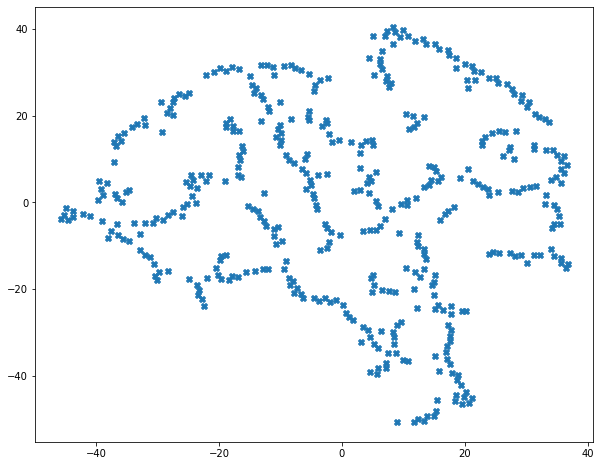

In [49]:
plt.figure(figsize=(10, 8))
plt.scatter(Z[:, 0], Z[:, 1], 
            cmap='Dark2', marker='X')

plt.show()

In [109]:
def cos_equal_matrix(size, matrix):            # составляем матрицу схожести предложений, которая использует 
    distances = np.zeros((size,size))          # формулу косинусного сходства для каждой пары предложений
    for first in range(size):
        for sec in range(size):
            distance = spatial.distance.cosine(matrix[first],matrix[sec])
            distances[first,sec] = distance
    return distances

In [110]:
def vec_from_sent(sent):                # Создаем вектор предложения - сумма всех векторов входящих слов,
    vec=[0] * 64                        # деленная на длину предложения
    for i in sent:
        if i in no_stopwords_list:
            vec+=model.wv[i]
    for el in range(len(vec)):
        vec[el]=vec[el]/len(sent)
    return vec

def matrix_from_text(arr):                # создаем матрицу из всех предложений на основе входящих в них слов
    matrix=[]
    for i in arr:
        matrix.append(vec_from_sent(i))
    return matrix

In [111]:
def sentWeight2(arr):
    sent_vec=vec_from_sent(list_of_words)  # создание вектора предложения
    

In [115]:
summilarity_matrix=cos_equal_matrix(len(arr_sent), matrix_from_text(arr_sent))
print(summilarity_matrix)


"""sent_with_weight=[]
for i in range(len(arr_sent)):
    weight=sentWeight(arr_sent[i])   #Считаем вес предложения
    sent_with_weight.append((weight, main_sent_lst[i])  #формируем список из пар веса и предложения
"""

[[0.         0.3898572  0.57634217 ... 0.50619387 0.60601127 0.6273299 ]
 [0.3898572  0.         0.40730198 ... 0.42578529 0.57692836 0.46614144]
 [0.57634217 0.40730198 0.         ... 0.58013319 0.75905719 0.6721684 ]
 ...
 [0.50619387 0.42578529 0.58013319 ... 0.         0.11280462 0.23804817]
 [0.60601127 0.57692836 0.75905719 ... 0.11280462 0.         0.31266527]
 [0.6273299  0.46614144 0.6721684  ... 0.23804817 0.31266527 0.        ]]


'sent_with_weight=[]\nfor i in range(len(arr_sent)):\n    weight=sentWeight(arr_sent[i])   #Считаем вес предложения\n    sent_with_weight.append((weight, main_sent_lst[i])  #формируем список из пар веса и предложения\n'

Вывод:

# Абстрактивная суммаризация

Предыдущий алгоритм просто составлял набор вырезанных предложений, которые несут в себе самую важную информацию, однако предложения не были связаны словами связками, логическим переходом мысли, то есть человеку такой "текст" читать неприятно и непонятно. Для того, чтобы сделать суммаризацию более осмысленной и приятной для чтения человеку используем нейронные сети.

In [5]:
import jsonlines
train=[]
with jsonlines.open("gazeta_train.jsonl") as ftrain:
    for line in ftrain.iter():
        train.append(line)
val=[]
with jsonlines.open("gazeta_val.jsonl") as fval:
    for line in fval.iter():
        val.append(line)
test=[]
with jsonlines.open("gazeta_test.jsonl") as ftest:
    for line in ftest.iter():
        test.append(line)

In [6]:
print(train[0].keys())
print(val[0].keys())
print(test[0].keys())

dict_keys(['date', 'url', 'summary', 'title', 'text'])
dict_keys(['date', 'url', 'summary', 'title', 'text'])
dict_keys(['date', 'url', 'summary', 'title', 'text'])
